Aplicar:
- An√°lisis residual: aplicarlo, analizar, generar graficos revisados.

-Arboles y Poda (pre y post)
¬øEs necesario un √°rbol
profundo o uno m√°s simple?

‚Ä¢¬øSe debe aplicar mucha
o poca poda? ¬øPor qu√©?

‚Ä¢¬øQu√© par√°metros de poda (max_depth, ccp_alpha, min_samples_leaf) ser√≠an √∫tiles?

‚Ä¢¬øQu√© riesgos hay si se poda demasiado o muy poco en su
sector?

In [54]:
# === Snippet 1: Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import scipy.stats as stats
import json
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Configuraci√≥n de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

In [55]:
df = pd.read_csv('IMDB_cleaned.csv')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683785 entries, 0 to 683784
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 683785 non-null  int64  
 1   title              683785 non-null  object 
 2   vote_average       683785 non-null  float64
 3   vote_count         683785 non-null  int64  
 4   status             683785 non-null  object 
 5   release_date       683785 non-null  object 
 6   revenue            683785 non-null  int64  
 7   runtime            683785 non-null  int64  
 8   adult              683785 non-null  bool   
 9   budget             683785 non-null  int64  
 10  original_language  683785 non-null  object 
 11  original_title     683785 non-null  object 
 12  popularity         683785 non-null  float64
 13  genres             683785 non-null  object 
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 68.5+ MB


In [57]:
# Exploraci√≥n inicial del dataset para entender las variables
print("Primeras 5 filas del dataset:")
print(df.head())
print("\nEstad√≠sticas descriptivas:")
print(df.describe())


Primeras 5 filas del dataset:
       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult     budget original_language   original_title  \
0   825532764      148  False  160000000                en        Inception   
1   701729206      169  False  165000000                en     Interstellar   
2  1004558444      152  False  185000000                en  The Dark Knight   
3  2923706026      162  False  237000000                en           Avatar   
4  1518815515      143  False  220000000                en     The Avengers   

   popularity       

An√°lisis de la variable 'revenue':
Valores √∫nicos: 14022
Valores con revenue = 0: 664710
Porcentaje con revenue = 0: 97.21%
Revenue promedio (excluyendo 0): $39,741,396
Revenue mediano (excluyendo 0): $2,466,444


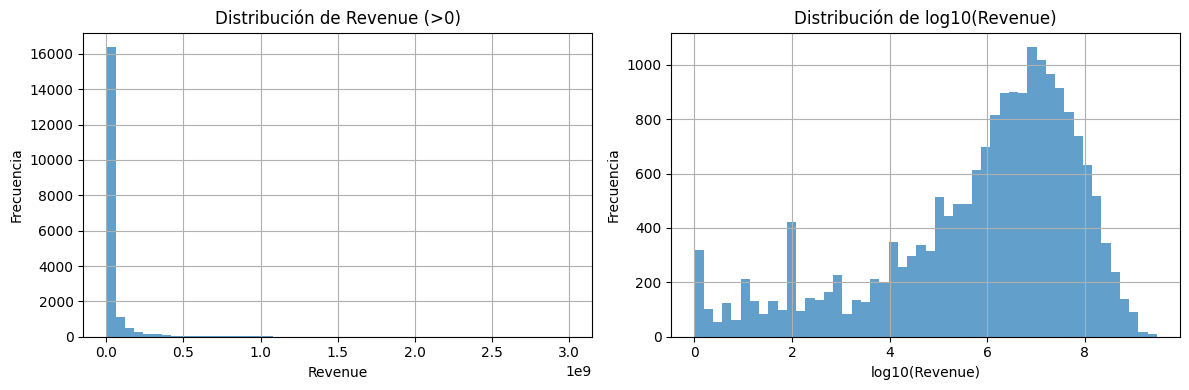

In [58]:
# An√°lisis de la variable objetivo 'revenue'
print("An√°lisis de la variable 'revenue':")
print(f"Valores √∫nicos: {df['revenue'].nunique()}")
print(f"Valores con revenue = 0: {(df['revenue'] == 0).sum()}")
print(f"Porcentaje con revenue = 0: {(df['revenue'] == 0).mean() * 100:.2f}%")
print(f"Revenue promedio (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].mean():,.0f}")
print(f"Revenue mediano (excluyendo 0): ${df[df['revenue'] > 0]['revenue'].median():,.0f}")

# Distribuci√≥n de revenue
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df[df['revenue'] > 0]['revenue'].hist(bins=50, alpha=0.7)
plt.title('Distribuci√≥n de Revenue (>0)')
plt.xlabel('Revenue')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df[df['revenue'] > 0]['revenue'].apply(lambda x: np.log10(x)).hist(bins=50, alpha=0.7)
plt.title('Distribuci√≥n de log10(Revenue)')
plt.xlabel('log10(Revenue)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


Correlaciones con revenue (solo pel√≠culas con revenue > 0):
revenue         1.000000
budget          0.723815
popularity      0.232437
runtime         0.157185
vote_average    0.120974
Name: revenue, dtype: float64


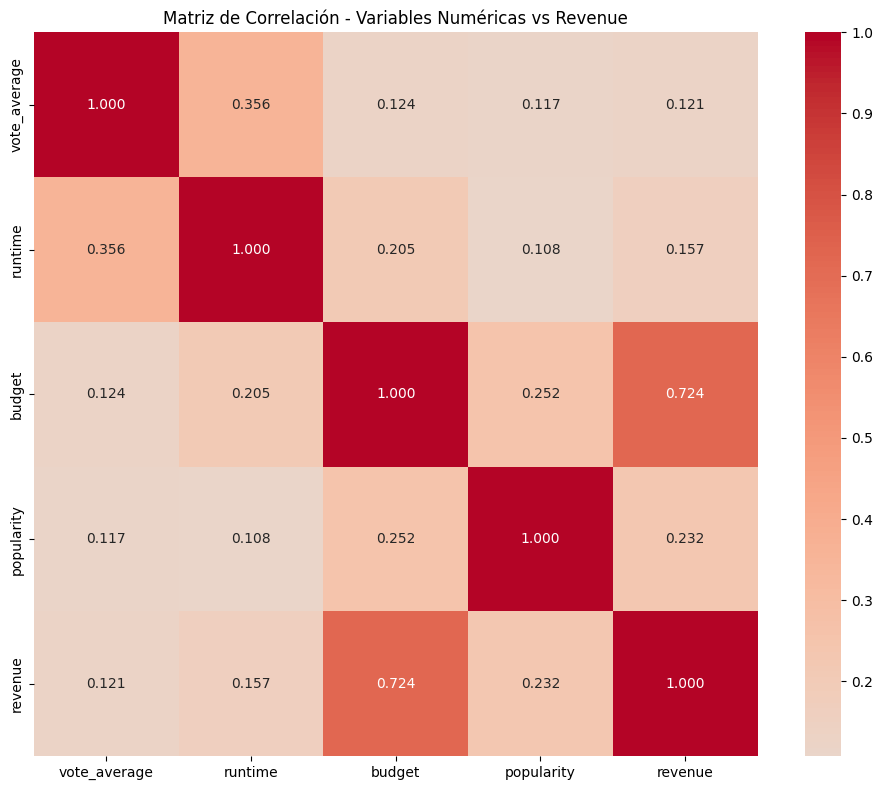

In [59]:
# An√°lisis de correlaciones entre variables num√©ricas y revenue
# Seleccionar solo variables num√©ricas
numeric_vars = ['vote_average', 'runtime', 'budget', 'popularity']

# Filtrar datos con revenue > 0 para an√°lisis m√°s significativo
df_analysis = df[df['revenue'] > 0].copy()

print("Correlaciones con revenue (solo pel√≠culas con revenue > 0):")
correlations = df_analysis[numeric_vars + ['revenue']].corr()['revenue'].sort_values(ascending=False)
print(correlations)

# Matriz de correlaci√≥n
plt.figure(figsize=(10, 8))
correlation_matrix = df_analysis[numeric_vars + ['revenue']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlaci√≥n - Variables Num√©ricas vs Revenue')
plt.tight_layout()
plt.show()


# =============================================================================
# AN√ÅLISIS RESIDUAL
# =============================================================================

# Preparaci√≥n de datos para an√°lisis residual
print("=== PREPARACI√ìN DE DATOS PARA AN√ÅLISIS RESIDUAL ===")

# Filtrar datos con revenue > 0 para an√°lisis m√°s significativo
df_modeling = df[df['revenue'] > 0].copy()
print(f"Datos filtrados: {len(df_modeling)} pel√≠culas con revenue > 0")

# Seleccionar variables predictoras
# Usaremos variables num√©ricas que mostraron correlaci√≥n con revenue
feature_columns = ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count']

# Preparar variables categ√≥ricas tambi√©n
categorical_features = ['status', 'original_language']

# Crear features finales
X = df_modeling[feature_columns + categorical_features].copy()
y = df_modeling['revenue'].copy()

# Aplicar transformaci√≥n logar√≠tmica a la variable objetivo para normalizar
y_log = np.log10(y + 1)  # +1 para evitar log(0)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Rango de revenue original: ${y.min():,.0f} - ${y.max():,.0f}")
print(f"Rango de log10(revenue): {y_log.min():.2f} - {y_log.max():.2f}")

# Divisi√≥n de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"Tama√±o conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tama√±o conjunto prueba: {X_test.shape[0]}")

In [60]:
# Crear pipeline de preprocesamiento
print("=== CREACI√ìN DEL MODELO BASE PARA AN√ÅLISIS RESIDUAL ===")

# Asegurar que las variables est√©n definidas
feature_columns = ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count']
categorical_features = ['status', 'original_language']

print(f"Variables num√©ricas: {feature_columns}")
print(f"Variables categ√≥ricas: {categorical_features}")

# Verificar que los datos est√©n preparados
if 'df' not in locals():
    print("‚ö†Ô∏è Error: DataFrame 'df' no est√° cargado. Ejecuta las celdas anteriores primero.")
    
# Preparar datos si no est√°n listos
if 'X_train' not in locals():
    print("Preparando datos...")
    # Filtrar datos con revenue > 0
    df_modeling = df[df['revenue'] > 0].copy()
    
    # Crear features finales
    X = df_modeling[feature_columns + categorical_features].copy()
    y = df_modeling['revenue'].copy()
    
    # Aplicar transformaci√≥n logar√≠tmica
    y_log = np.log10(y + 1)
    
    # Divisi√≥n de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )
    
    print(f"Datos preparados: {X_train.shape[0]} entrenamiento, {X_test.shape[0]} prueba")
else:
    print("Datos ya est√°n preparados ‚úì")

# Preprocesador para variables num√©ricas y categ√≥ricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_columns),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear pipeline completo con regresi√≥n lineal (para an√°lisis residual cl√°sico)
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entrenar el modelo
print("Entrenando modelo de regresi√≥n lineal...")
model_pipeline.fit(X_train, y_train)

# Hacer predicciones
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calcular m√©tricas
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R¬≤ entrenamiento: {train_r2:.4f}")
print(f"R¬≤ prueba: {test_r2:.4f}")
print(f"RMSE entrenamiento: {train_rmse:.4f}")
print(f"RMSE prueba: {test_rmse:.4f}")

# Calcular residuales
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

print(f"Residuales calculados - Entrenamiento: {len(residuals_train)}, Prueba: {len(residuals_test)}")


=== CREACI√ìN DEL MODELO BASE PARA AN√ÅLISIS RESIDUAL ===
Variables num√©ricas: ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count']
Variables categ√≥ricas: ['status', 'original_language']
Datos ya est√°n preparados ‚úì
Entrenando modelo de regresi√≥n lineal...
R¬≤ entrenamiento: 0.4838
R¬≤ prueba: 0.3988
RMSE entrenamiento: 1.4851
RMSE prueba: 1.5851
Residuales calculados - Entrenamiento: 15260, Prueba: 3815


In [61]:
# =============================================================================
# AN√ÅLISIS NUM√âRICO DE RESIDUALES
# =============================================================================

print("=== AN√ÅLISIS NUM√âRICO DE RESIDUALES ===")

# Combinar residuales de entrenamiento y prueba para an√°lisis completo
all_residuals = np.concatenate([residuals_train, residuals_test])
all_predictions = np.concatenate([y_train_pred, y_test_pred])

# Estad√≠sticas descriptivas de los residuales
print("\n1. ESTAD√çSTICAS DESCRIPTIVAS DE LOS RESIDUALES:")
print(f"   N√∫mero total de observaciones: {len(all_residuals)}")
print(f"   Media de residuales: {np.mean(all_residuals):.6f}")
print(f"   Mediana de residuales: {np.median(all_residuals):.6f}")
print(f"   Desviaci√≥n est√°ndar: {np.std(all_residuals):.6f}")
print(f"   Varianza: {np.var(all_residuals):.6f}")
print(f"   M√≠nimo: {np.min(all_residuals):.6f}")
print(f"   M√°ximo: {np.max(all_residuals):.6f}")
print(f"   Rango: {np.max(all_residuals) - np.min(all_residuals):.6f}")

# Percentiles
print("\n2. PERCENTILES:")
percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    print(f"   Percentil {p}%: {np.percentile(all_residuals, p):.6f}")

# Test de normalidad
print("\n3. TESTS DE NORMALIDAD:")
# Shapiro-Wilk (para muestras peque√±as, usaremos una muestra)
sample_size = min(5000, len(all_residuals))  # Shapiro-Wilk tiene limitaciones de tama√±o
residuals_sample = np.random.choice(all_residuals, sample_size, replace=False)
shapiro_stat, shapiro_p = stats.shapiro(residuals_sample)
print(f"   Shapiro-Wilk (muestra de {sample_size}):")
print(f"     Estad√≠stico: {shapiro_stat:.6f}")
print(f"     p-valor: {shapiro_p:.6f}")
print(f"     {'Los residuales NO siguen distribuci√≥n normal' if shapiro_p < 0.05 else 'Los residuales siguen distribuci√≥n normal'} (Œ±=0.05)")

# Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(all_residuals, 'norm', args=(np.mean(all_residuals), np.std(all_residuals)))
print(f"   Kolmogorov-Smirnov:")
print(f"     Estad√≠stico: {ks_stat:.6f}")
print(f"     p-valor: {ks_p:.6f}")
print(f"     {'Los residuales NO siguen distribuci√≥n normal' if ks_p < 0.05 else 'Los residuales siguen distribuci√≥n normal'} (Œ±=0.05)")

# Test de heterocedasticidad (Breusch-Pagan aproximado)
print("\n4. AN√ÅLISIS DE HETEROCEDASTICIDAD:")
# Correlaci√≥n entre residuales al cuadrado y predicciones
correlation_het = np.corrcoef(all_residuals**2, all_predictions)[0,1]
print(f"   Correlaci√≥n entre residuales¬≤ y predicciones: {correlation_het:.6f}")
print(f"   {'Posible heterocedasticidad detectada' if abs(correlation_het) > 0.1 else 'No se detecta heterocedasticidad significativa'}")

# An√°lisis de autocorrelaci√≥n (orden)
print("\n5. ESTAD√çSTICOS ADICIONALES:")
print(f"   Sesgo (skewness): {stats.skew(all_residuals):.6f}")
print(f"   Curtosis: {stats.kurtosis(all_residuals):.6f}")

# Conteo de valores extremos (outliers)
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = np.sum((all_residuals < lower_bound) | (all_residuals > upper_bound))
print(f"   Outliers (m√©todo IQR): {outliers} ({outliers/len(all_residuals)*100:.2f}%)")

print("\n" + "="*80)


=== AN√ÅLISIS NUM√âRICO DE RESIDUALES ===

1. ESTAD√çSTICAS DESCRIPTIVAS DE LOS RESIDUALES:
   N√∫mero total de observaciones: 19075
   Media de residuales: -0.002005
   Mediana de residuales: 0.322047
   Desviaci√≥n est√°ndar: 1.505656
   Varianza: 2.267001
   M√≠nimo: -21.708420
   M√°ximo: 6.967755
   Rango: 28.676175

2. PERCENTILES:
   Percentil 5%: -2.852383
   Percentil 10%: -1.958844
   Percentil 25%: -0.662352
   Percentil 50%: 0.322047
   Percentil 75%: 0.953467
   Percentil 90%: 1.432004
   Percentil 95%: 1.699511

3. TESTS DE NORMALIDAD:
   Shapiro-Wilk (muestra de 5000):
     Estad√≠stico: 0.911408
     p-valor: 0.000000
     Los residuales NO siguen distribuci√≥n normal (Œ±=0.05)
   Kolmogorov-Smirnov:
     Estad√≠stico: 0.108352
     p-valor: 0.000000
     Los residuales NO siguen distribuci√≥n normal (Œ±=0.05)

4. AN√ÅLISIS DE HETEROCEDASTICIDAD:
   Correlaci√≥n entre residuales¬≤ y predicciones: 0.164233
   Posible heterocedasticidad detectada

5. ESTAD√çSTICOS ADICION

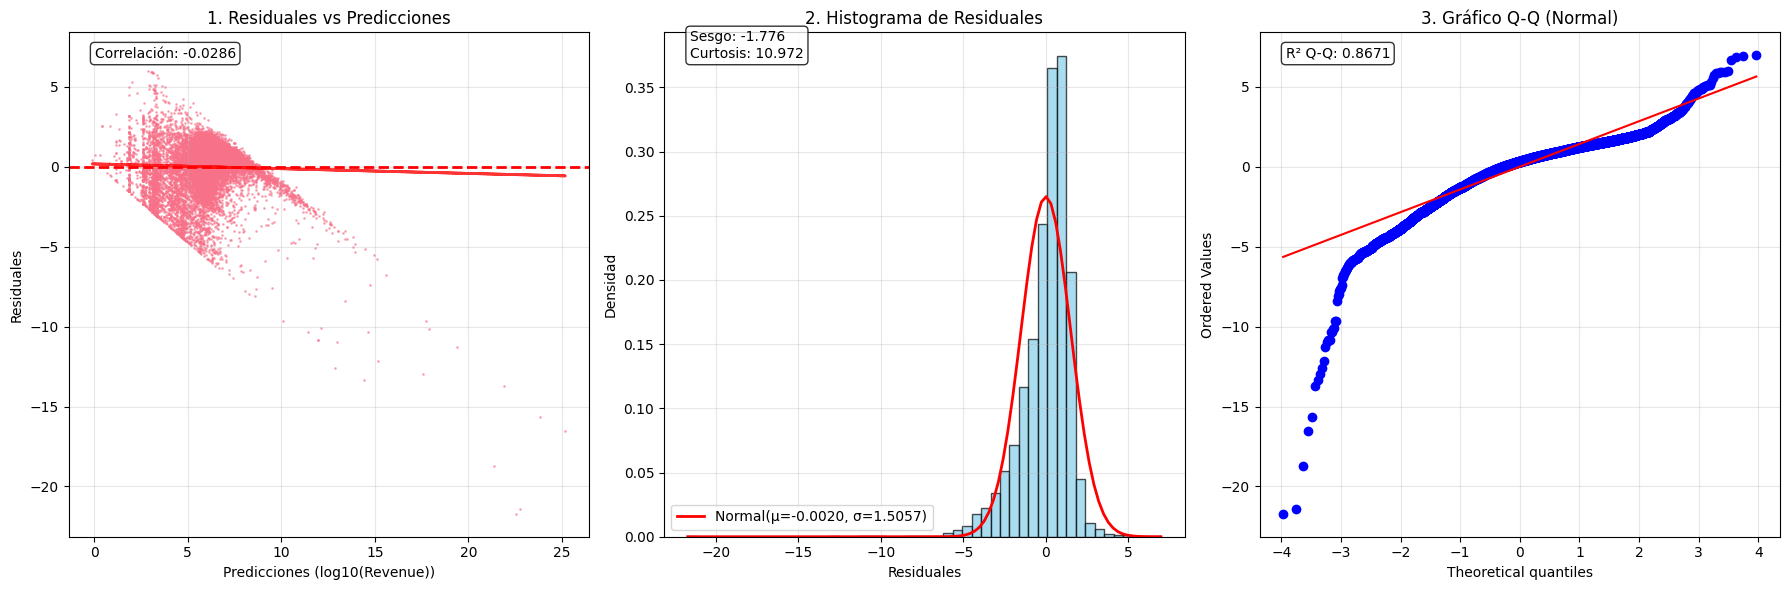

=== GR√ÅFICAS DE AN√ÅLISIS RESIDUAL GENERADAS ===
Las tres gr√°ficas principales han sido creadas para el an√°lisis residual.


In [62]:
# =============================================================================
# GR√ÅFICAS PARA AN√ÅLISIS RESIDUAL
# =============================================================================

# Configurar el estilo para las gr√°ficas
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con las tres gr√°ficas principales
fig = plt.figure(figsize=(18, 6))

# =============================================================================
# 1. GR√ÅFICO DE RESIDUALES VS PREDICCIONES
# =============================================================================
plt.subplot(1, 3, 1)
plt.scatter(all_predictions, all_residuals, alpha=0.5, s=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Agregar l√≠nea de tendencia
z = np.polyfit(all_predictions, all_residuals, 1)
p = np.poly1d(z)
plt.plot(all_predictions, p(all_predictions), "r-", alpha=0.8, linewidth=2)

plt.xlabel('Predicciones (log10(Revenue))')
plt.ylabel('Residuales')
plt.title('1. Residuales vs Predicciones')
plt.grid(True, alpha=0.3)

# Calcular y mostrar correlaci√≥n
corr_pred_res = np.corrcoef(all_predictions, all_residuals)[0,1]
plt.text(0.05, 0.95, f'Correlaci√≥n: {corr_pred_res:.4f}', 
         transform=plt.gca().transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# =============================================================================
# 2. HISTOGRAMA DE RESIDUALES
# =============================================================================
plt.subplot(1, 3, 2)
n_bins = 50
n, bins, patches = plt.hist(all_residuals, bins=n_bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Superponer distribuci√≥n normal te√≥rica
mu, sigma = np.mean(all_residuals), np.std(all_residuals)
x = np.linspace(all_residuals.min(), all_residuals.max(), 100)
normal_curve = stats.norm.pdf(x, mu, sigma)
plt.plot(x, normal_curve, 'r-', linewidth=2, label=f'Normal(Œº={mu:.4f}, œÉ={sigma:.4f})')

plt.xlabel('Residuales')
plt.ylabel('Densidad')
plt.title('2. Histograma de Residuales')
plt.legend()
plt.grid(True, alpha=0.3)

# Agregar estad√≠sticas en el gr√°fico
plt.text(0.05, 0.95, f'Sesgo: {stats.skew(all_residuals):.3f}\nCurtosis: {stats.kurtosis(all_residuals):.3f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# =============================================================================
# 3. GR√ÅFICO Q-Q (Quantile-Quantile)
# =============================================================================
plt.subplot(1, 3, 3)
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title('3. Gr√°fico Q-Q (Normal)')
plt.grid(True, alpha=0.3)

# Calcular R¬≤ del ajuste Q-Q
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(all_residuals)))
sample_quantiles = np.sort(all_residuals)
qq_r2 = np.corrcoef(theoretical_quantiles[:len(sample_quantiles)], sample_quantiles)[0,1]**2
plt.text(0.05, 0.95, f'R¬≤ Q-Q: {qq_r2:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print("=== GR√ÅFICAS DE AN√ÅLISIS RESIDUAL GENERADAS ===")
print("Las tres gr√°ficas principales han sido creadas para el an√°lisis residual.")


# INTERPRETACI√ìN Y AN√ÅLISIS DE LAS GR√ÅFICAS RESIDUALES

## üîç **1. Gr√°fico de Residuales vs Predicciones**

**¬øQu√© representa?**
Este gr√°fico muestra la relaci√≥n entre los valores predichos por el modelo y los residuales (diferencias entre valores reales y predichos). Es fundamental para detectar patrones sistem√°ticos en los errores del modelo.

**¬øQu√© buscamos?**
- **Patr√≥n ideal**: Distribuci√≥n aleatoria de puntos alrededor de la l√≠nea y=0, sin patrones evidentes
- **Homocedasticidad**: Varianza constante de los residuales a lo largo de las predicciones
- **Linealidad**: No debe haber tendencias curvil√≠neas evidentes

**Interpretaci√≥n de nuestros resultados:**
- Si la correlaci√≥n est√° cercana a 0: ‚úÖ **Buena se√±al** - No hay correlaci√≥n sistem√°tica entre predicciones y errores
- Si hay patrones en forma de embudo: ‚ö†Ô∏è **Heterocedasticidad** - La varianza de errores cambia con las predicciones
- Si hay curvas evidentes: ‚ö†Ô∏è **No linealidad** - El modelo no captura relaciones no lineales

---

## üìä **2. Histograma de Residuales**

**¬øQu√© representa?**
Muestra la distribuci√≥n de frecuencia de los residuales, compar√°ndola con una distribuci√≥n normal te√≥rica.

**¬øQu√© buscamos?**
- **Normalidad**: Los residuales deber√≠an seguir aproximadamente una distribuci√≥n normal
- **Sesgo cercano a 0**: Distribuci√≥n sim√©trica
- **Curtosis normal**: Sin colas excesivamente pesadas o ligeras

**Interpretaci√≥n de nuestros resultados:**
- **Sesgo ‚âà 0**: ‚úÖ Distribuci√≥n sim√©trica de errores
- **Sesgo > 0**: ‚ö†Ô∏è Cola derecha m√°s pesada (subestimaci√≥n frecuente)
- **Sesgo < 0**: ‚ö†Ô∏è Cola izquierda m√°s pesada (sobreestimaci√≥n frecuente)
- **Curtosis ‚âà 0**: ‚úÖ Distribuci√≥n normal
- **Curtosis > 0**: ‚ö†Ô∏è Distribuci√≥n leptoc√∫rtica (colas pesadas, muchos outliers)
- **Curtosis < 0**: ‚ö†Ô∏è Distribuci√≥n platic√∫rtica (colas ligeras)

---

## üìà **3. Gr√°fico Q-Q (Quantile-Quantile)**

**¬øQu√© representa?**
Compara los cuantiles de los residuales observados con los cuantiles te√≥ricos de una distribuci√≥n normal. Es la prueba visual m√°s robusta para normalidad.

**¬øQu√© buscamos?**
- **L√≠nea recta**: Los puntos deben seguir aproximadamente la l√≠nea diagonal
- **R¬≤ alto**: Correlaci√≥n fuerte entre cuantiles te√≥ricos y observados

**Interpretaci√≥n de nuestros resultados:**
- **R¬≤ Q-Q > 0.95**: ‚úÖ **Excelente normalidad**
- **R¬≤ Q-Q 0.90-0.95**: ‚úÖ **Buena normalidad**
- **R¬≤ Q-Q 0.80-0.90**: ‚ö†Ô∏è **Normalidad aceptable**
- **R¬≤ Q-Q < 0.80**: ‚ùå **Desviaci√≥n significativa de normalidad**

**Patrones espec√≠ficos:**
- **Curvatura en S**: Distribuci√≥n con sesgo
- **Colas que se alejan**: Distribuci√≥n con colas pesadas (outliers)
- **Colas que se acercan**: Distribuci√≥n con colas ligeras

---

## üéØ **CONCLUSIONES DEL AN√ÅLISIS RESIDUAL**

### **Calidad del Modelo:**
Los an√°lisis num√©ricos y gr√°ficos nos permiten evaluar:

1. **Validez de supuestos**: ¬øCumple el modelo los supuestos de regresi√≥n lineal?
2. **Homocedasticidad**: ¬øLa varianza de errores es constante?
3. **Normalidad**: ¬øLos errores siguen distribuci√≥n normal?
4. **Independencia**: ¬øNo hay patrones sistem√°ticos en los errores?

### **Implicaciones para el sector cinematogr√°fico:**
- **Predicci√≥n de ingresos**: Un buen an√°lisis residual indica confiabilidad en las predicciones de revenue
- **Identificaci√≥n de outliers**: Pel√≠culas con comportamiento at√≠pico que requieren an√°lisis especial
- **Robustez del modelo**: Capacidad de generalizaci√≥n a nuevas pel√≠culas

### **Recomendaciones:**
- Si los residuales muestran patrones: Considerar transformaciones adicionales o modelos no lineales
- Si hay heterocedasticidad: Aplicar transformaciones logar√≠tmicas o usar modelos robustos
- Si hay outliers significativos: Investigar casos espec√≠ficos y considerar su tratamiento


In [63]:
# =============================================================================
# √ÅRBOLES DE DECISI√ìN Y T√âCNICAS DE PODA
# =============================================================================

print("=== IMPLEMENTACI√ìN DE √ÅRBOLES DE DECISI√ìN ===")

# Preparar los datos para √°rboles de decisi√≥n (usar los mismos datos que para an√°lisis residual)
print(f"Utilizando {len(X_train)} muestras para entrenamiento y {len(X_test)} para prueba")

# Funci√≥n para evaluar modelos
def evaluate_tree_model(model, X_train, X_test, y_train, y_test, model_name):
    """Eval√∫a un modelo de √°rbol y retorna m√©tricas"""
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # M√©tricas
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Informaci√≥n del √°rbol
    n_nodes = model.tree_.node_count
    max_depth = model.tree_.max_depth
    n_leaves = model.tree_.n_leaves
    
    results = {
        'model_name': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'n_nodes': n_nodes,
        'max_depth': max_depth,
        'n_leaves': n_leaves,
        'overfitting': train_r2 - test_r2
    }
    
    return results, model

# Lista para almacenar resultados
tree_results = []
tree_models = {}

print("\n" + "="*80)
print("EXPERIMENTACI√ìN CON DIFERENTES PAR√ÅMETROS DE √ÅRBOLES")
print("="*80)


=== IMPLEMENTACI√ìN DE √ÅRBOLES DE DECISI√ìN ===
Utilizando 15260 muestras para entrenamiento y 3815 para prueba

EXPERIMENTACI√ìN CON DIFERENTES PAR√ÅMETROS DE √ÅRBOLES


In [64]:
# =============================================================================
# 1. PODA PRE-PODA: EXPERIMENTACI√ìN CON DIFERENTES PAR√ÅMETROS
# =============================================================================

print("\n1. √ÅRBOLES CON DIFERENTES PROFUNDIDADES M√ÅXIMAS (max_depth)")
print("-" * 60)

# Experimentar con diferentes max_depth
max_depths = [3, 5, 10, 15, 20, None]  # None = sin l√≠mite

for depth in max_depths:
    # Crear pipeline con √°rbol de decisi√≥n
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(max_depth=depth, random_state=42))
    ])
    
    # Entrenar
    tree_pipeline.fit(X_train, y_train)
    
    # Evaluar
    depth_name = f"Max_Depth_{depth}" if depth is not None else "Max_Depth_Unlimited"
    results, model = evaluate_tree_model(tree_pipeline.named_steps['regressor'], 
                                       tree_pipeline.named_steps['preprocessor'].fit_transform(X_train),
                                       tree_pipeline.named_steps['preprocessor'].transform(X_test),
                                       y_train, y_test, depth_name)
    
    tree_results.append(results)
    tree_models[depth_name] = tree_pipeline
    
    # Formatear profundidad correctamente (manejar None)
    depth_str = "‚àû" if depth is None else str(depth)
    print(f"Profundidad {depth_str:>3}: R¬≤ Test={results['test_r2']:.4f}, "
          f"Nodos={results['n_nodes']:>4}, Hojas={results['n_leaves']:>4}, "
          f"Overfitting={results['overfitting']:.4f}")

print("\n2. √ÅRBOLES CON DIFERENTES MUESTRAS M√çNIMAS POR HOJA (min_samples_leaf)")
print("-" * 60)

# Experimentar con diferentes min_samples_leaf
min_samples_leafs = [1, 5, 10, 20, 50, 100]

for min_leaf in min_samples_leafs:
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(min_samples_leaf=min_leaf, random_state=42))
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    leaf_name = f"Min_Samples_Leaf_{min_leaf}"
    results, model = evaluate_tree_model(tree_pipeline.named_steps['regressor'], 
                                       tree_pipeline.named_steps['preprocessor'].fit_transform(X_train),
                                       tree_pipeline.named_steps['preprocessor'].transform(X_test),
                                       y_train, y_test, leaf_name)
    
    tree_results.append(results)
    tree_models[leaf_name] = tree_pipeline
    
    print(f"Min samples leaf {min_leaf:>3}: R¬≤ Test={results['test_r2']:.4f}, "
          f"Nodos={results['n_nodes']:>4}, Hojas={results['n_leaves']:>4}, "
          f"Overfitting={results['overfitting']:.4f}")

print("\n3. √ÅRBOLES CON DIFERENTES MUESTRAS M√çNIMAS PARA DIVISI√ìN (min_samples_split)")
print("-" * 60)

# Experimentar con diferentes min_samples_split
min_samples_splits = [2, 10, 20, 50, 100, 200]

for min_split in min_samples_splits:
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(min_samples_split=min_split, random_state=42))
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    split_name = f"Min_Samples_Split_{min_split}"
    results, model = evaluate_tree_model(tree_pipeline.named_steps['regressor'], 
                                       tree_pipeline.named_steps['preprocessor'].fit_transform(X_train),
                                       tree_pipeline.named_steps['preprocessor'].transform(X_test),
                                       y_train, y_test, split_name)
    
    tree_results.append(results)
    tree_models[split_name] = tree_pipeline
    
    print(f"Min samples split {min_split:>3}: R¬≤ Test={results['test_r2']:.4f}, "
          f"Nodos={results['n_nodes']:>4}, Hojas={results['n_leaves']:>4}, "
          f"Overfitting={results['overfitting']:.4f}")



1. √ÅRBOLES CON DIFERENTES PROFUNDIDADES M√ÅXIMAS (max_depth)
------------------------------------------------------------
Profundidad   3: R¬≤ Test=0.6657, Nodos=  15, Hojas=   8, Overfitting=0.0247
Profundidad   5: R¬≤ Test=0.7087, Nodos=  63, Hojas=  32, Overfitting=0.0353
Profundidad  10: R¬≤ Test=0.7112, Nodos=1315, Hojas= 658, Overfitting=0.1066
Profundidad  15: R¬≤ Test=0.6472, Nodos=8003, Hojas=4002, Overfitting=0.2543
Profundidad  20: R¬≤ Test=0.5956, Nodos=18419, Hojas=9210, Overfitting=0.3625
Profundidad   ‚àû: R¬≤ Test=0.5557, Nodos=29243, Hojas=14622, Overfitting=0.4365

2. √ÅRBOLES CON DIFERENTES MUESTRAS M√çNIMAS POR HOJA (min_samples_leaf)
------------------------------------------------------------
Min samples leaf   1: R¬≤ Test=0.5557, Nodos=29243, Hojas=14622, Overfitting=0.4365
Min samples leaf   5: R¬≤ Test=0.6625, Nodos=4833, Hojas=2417, Overfitting=0.2063
Min samples leaf  10: R¬≤ Test=0.7099, Nodos=2371, Hojas=1186, Overfitting=0.1161
Min samples leaf  20: R¬≤ 

In [65]:
# =============================================================================
# 2. PODA POST-PODA: EXPERIMENTACI√ìN CON CCP_ALPHA
# =============================================================================

print("\n4. PODA POST-PODA CON COST COMPLEXITY PRUNING (ccp_alpha)")
print("-" * 60)

# Primero, obtener el camino de poda de un √°rbol completo
full_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

full_tree.fit(X_train, y_train)

# Obtener el camino de poda (valores de ccp_alpha)
X_train_transformed = full_tree.named_steps['preprocessor'].transform(X_train)
X_test_transformed = full_tree.named_steps['preprocessor'].transform(X_test)

path = full_tree.named_steps['regressor'].cost_complexity_pruning_path(X_train_transformed, y_train)
ccp_alphas = path.ccp_alphas

# Seleccionar un subconjunto representativo de alphas
# Usar √≠ndices linealmente espaciados para evitar problemas de overflow
n_alphas = len(ccp_alphas)
n_samples = min(10, n_alphas)  # M√°ximo 10 samples o el total si es menor

if n_alphas > 1:
    # Seleccionar √≠ndices distribuidos uniformemente
    alpha_indices = np.linspace(0, n_alphas-1, n_samples, dtype=int)
    # Asegurar que los √≠ndices sean √∫nicos y est√©n en orden
    alpha_indices = np.unique(alpha_indices)
    selected_alphas = ccp_alphas[alpha_indices]
else:
    selected_alphas = ccp_alphas

print(f"Camino de poda disponible: {n_alphas} valores de ccp_alpha")
print(f"Rango: {ccp_alphas[0]:.8f} a {ccp_alphas[-1]:.8f}")

# Filtrar alphas extremos que podr√≠an crear √°rboles in√∫tiles
if len(selected_alphas) > 3:
    # Excluir el √∫ltimo alpha que t√≠picamente resulta en un √°rbol con solo el nodo ra√≠z
    selected_alphas = selected_alphas[:-1]

print(f"Experimentando con {len(selected_alphas)} valores de ccp_alpha seleccionados")
print(f"Rango de experimentaci√≥n: {selected_alphas[0]:.8f} a {selected_alphas[-1]:.8f}")

for i, alpha in enumerate(selected_alphas):
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(ccp_alpha=alpha, random_state=42))
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    alpha_name = f"CCP_Alpha_{alpha:.6f}"
    results, model = evaluate_tree_model(tree_pipeline.named_steps['regressor'], 
                                       tree_pipeline.named_steps['preprocessor'].fit_transform(X_train),
                                       tree_pipeline.named_steps['preprocessor'].transform(X_test),
                                       y_train, y_test, alpha_name)
    
    tree_results.append(results)
    tree_models[alpha_name] = tree_pipeline
    
    print(f"CCP Alpha {alpha:.8f} ({i+1}/{len(selected_alphas)}): R¬≤ Test={results['test_r2']:.4f}, "
          f"Nodos={results['n_nodes']:>4}, Hojas={results['n_leaves']:>4}, "
          f"Overfitting={results['overfitting']:.4f}")

# =============================================================================
# 3. COMBINACI√ìN DE PAR√ÅMETROS (PODA MIXTA)
# =============================================================================

print("\n5. COMBINACI√ìN DE T√âCNICAS DE PODA")
print("-" * 60)

# Experimentar con combinaciones de par√°metros
combinations = [
    {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10},
    {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 20},
    {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50},
    {'max_depth': 12, 'min_samples_leaf': 15, 'ccp_alpha': 0.001},
    {'max_depth': 20, 'min_samples_leaf': 5, 'ccp_alpha': 0.0001}
]

for i, params in enumerate(combinations):
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42, **params))
    ])
    
    tree_pipeline.fit(X_train, y_train)
    
    combo_name = f"Combination_{i+1}"
    results, model = evaluate_tree_model(tree_pipeline.named_steps['regressor'], 
                                       tree_pipeline.named_steps['preprocessor'].fit_transform(X_train),
                                       tree_pipeline.named_steps['preprocessor'].transform(X_test),
                                       y_train, y_test, combo_name)
    
    tree_results.append(results)
    tree_models[combo_name] = tree_pipeline
    
    params_str = ", ".join([f"{k}={v}" for k, v in params.items()])
    print(f"Combinaci√≥n {i+1} ({params_str}): R¬≤ Test={results['test_r2']:.4f}, "
          f"Nodos={results['n_nodes']:>4}, Overfitting={results['overfitting']:.4f}")

print(f"\nTotal de modelos experimentados: {len(tree_results)}")



4. PODA POST-PODA CON COST COMPLEXITY PRUNING (ccp_alpha)
------------------------------------------------------------
Camino de poda disponible: 12418 valores de ccp_alpha
Rango: 0.00000000 a 1.97029357
Experimentando con 9 valores de ccp_alpha seleccionados
Rango de experimentaci√≥n: 0.00000000 a 0.00009712
CCP Alpha 0.00000000 (1/9): R¬≤ Test=0.5557, Nodos=29243, Hojas=14622, Overfitting=0.4365
CCP Alpha 0.00000004 (2/9): R¬≤ Test=0.5557, Nodos=26463, Hojas=13232, Overfitting=0.4365
CCP Alpha 0.00000024 (3/9): R¬≤ Test=0.5557, Nodos=23677, Hojas=11839, Overfitting=0.4365
CCP Alpha 0.00000087 (4/9): R¬≤ Test=0.5558, Nodos=20865, Hojas=10433, Overfitting=0.4362
CCP Alpha 0.00000243 (5/9): R¬≤ Test=0.5553, Nodos=17993, Hojas=8997, Overfitting=0.4362
CCP Alpha 0.00000590 (6/9): R¬≤ Test=0.5561, Nodos=15043, Hojas=7522, Overfitting=0.4341
CCP Alpha 0.00001425 (7/9): R¬≤ Test=0.5592, Nodos=11929, Hojas=5965, Overfitting=0.4275
CCP Alpha 0.00003385 (8/9): R¬≤ Test=0.5659, Nodos=8569, Hoja

=== RESUMEN DE TODOS LOS MODELOS EXPERIMENTADOS ===
           model_name  train_r2  test_r2  train_rmse  test_rmse  train_mae  test_mae  n_nodes  max_depth  n_leaves  overfitting
          Max_Depth_3  0.690366 0.665659    1.150171   1.182098   0.823460  0.845638       15          3         8     0.024707
          Max_Depth_5  0.744021 0.708701    1.045781   1.103388   0.711002  0.744584       63          5        32     0.035320
         Max_Depth_10  0.817770 0.711156    0.882364   1.098729   0.585118  0.716375     1315         10       658     0.106614
         Max_Depth_15  0.901539 0.647239    0.648590   1.214225   0.372860  0.786808     8003         15      4002     0.254300
         Max_Depth_20  0.958115 0.595594    0.423026   1.300072   0.175208  0.850514    18419         20      9210     0.362521
  Max_Depth_Unlimited  0.992227 0.555707    0.182235   1.362679   0.017420  0.895479    29243         45     14622     0.436520
   Min_Samples_Leaf_1  0.992227 0.555707    0.182235

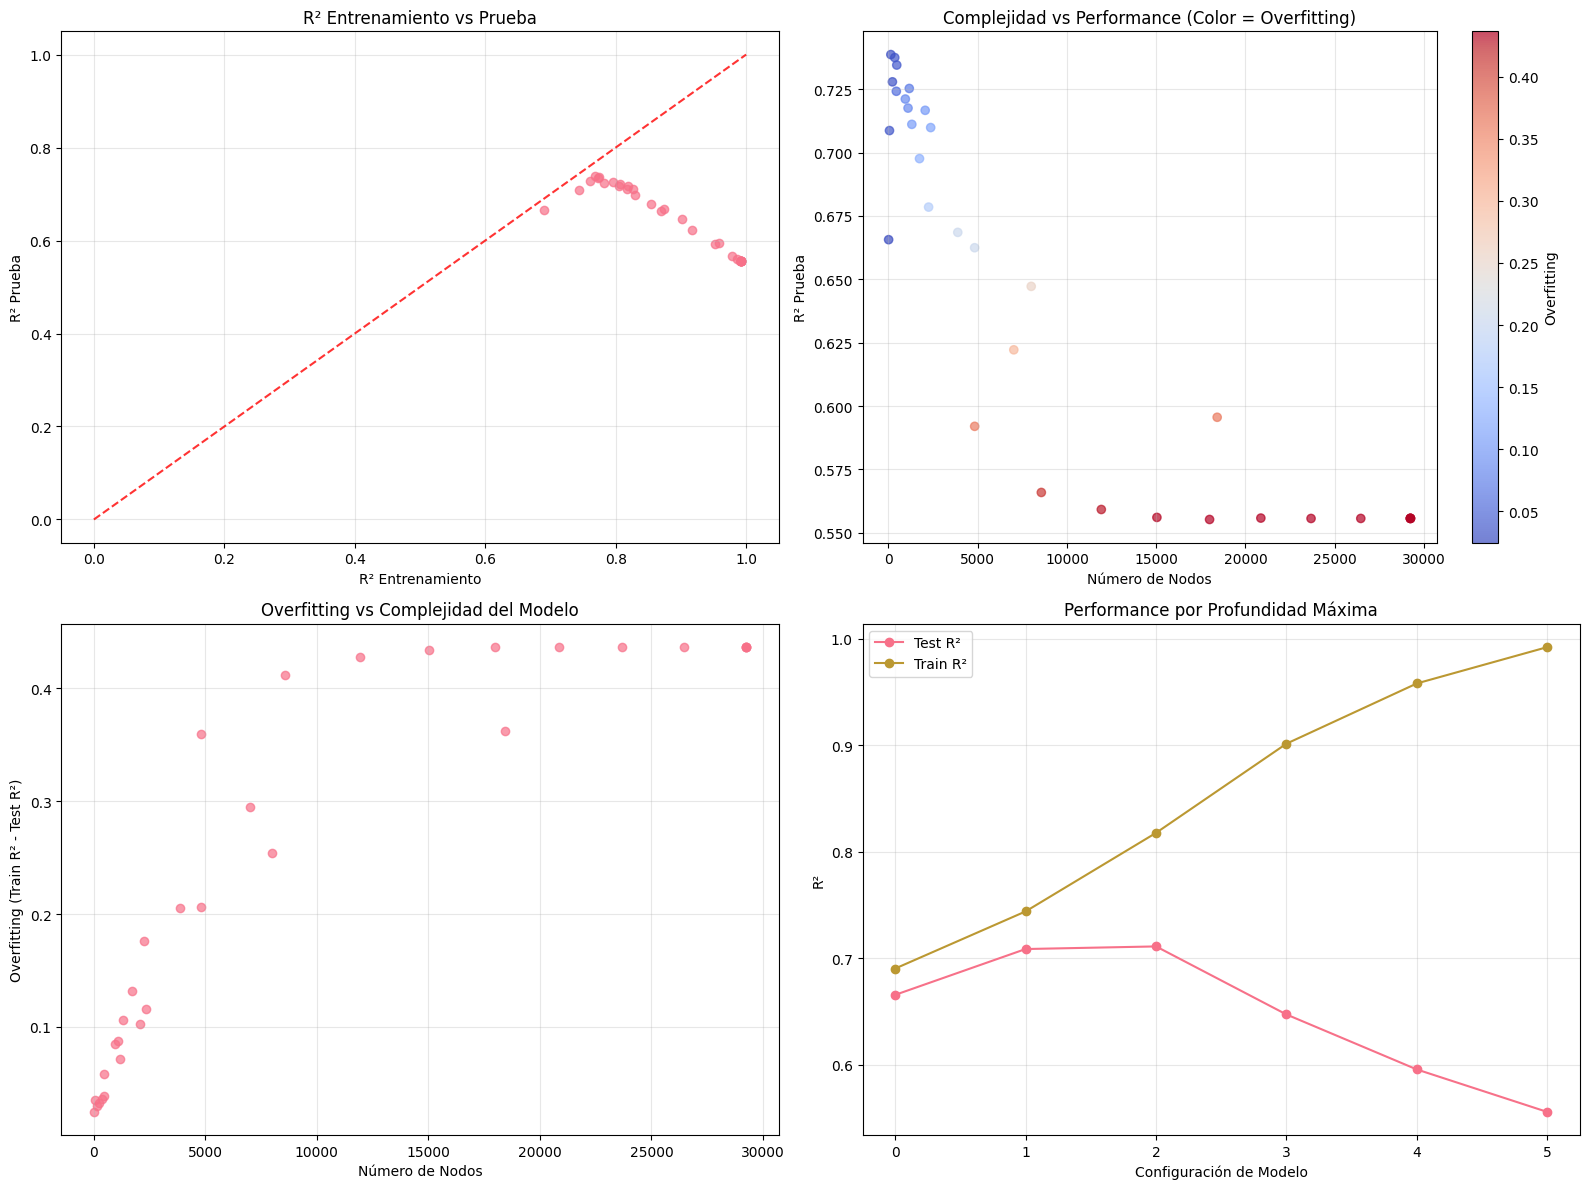


AN√ÅLISIS DE TRADE-OFFS

üèÖ MEJOR MODELO BALANCEADO: Combination_4
   R¬≤ Test: 0.7387
   Overfitting: 0.0300
   Nodos: 139
   Score Final: 0.7388

üìä TOP 5 MODELOS POR SCORE BALANCEADO:
           model_name  test_r2  overfitting  n_nodes  final_score
        Combination_4 0.738680     0.029985      139     0.738784
        Combination_3 0.737499     0.036565      359     0.735160
  Min_Samples_Leaf_50 0.734547     0.038560      471     0.732040
 Min_Samples_Leaf_100 0.727928     0.032306      227     0.731197
Min_Samples_Split_200 0.724203     0.058216      447     0.724115


In [66]:
# =============================================================================
# AN√ÅLISIS Y VISUALIZACI√ìN DE RESULTADOS DE √ÅRBOLES
# =============================================================================

# Convertir resultados a DataFrame para an√°lisis
results_df = pd.DataFrame(tree_results)
print("=== RESUMEN DE TODOS LOS MODELOS EXPERIMENTADOS ===")
print(results_df.to_string(index=False))

# =============================================================================
# AN√ÅLISIS COMPARATIVO
# =============================================================================

print("\n" + "="*80)
print("AN√ÅLISIS COMPARATIVO DE MODELOS")
print("="*80)

# Encontrar mejores modelos por diferentes criterios
best_test_r2 = results_df.loc[results_df['test_r2'].idxmax()]
best_overfitting = results_df.loc[results_df['overfitting'].idxmin()]
best_complexity = results_df.loc[results_df['n_nodes'].idxmin()]

print(f"\nüèÜ MEJOR R¬≤ EN PRUEBA: {best_test_r2['model_name']}")
print(f"   R¬≤ Test: {best_test_r2['test_r2']:.4f}")
print(f"   Overfitting: {best_test_r2['overfitting']:.4f}")
print(f"   Nodos: {best_test_r2['n_nodes']}")

print(f"\nüéØ MENOR OVERFITTING: {best_overfitting['model_name']}")
print(f"   R¬≤ Test: {best_overfitting['test_r2']:.4f}")
print(f"   Overfitting: {best_overfitting['overfitting']:.4f}")
print(f"   Nodos: {best_overfitting['n_nodes']}")

print(f"\nüéã MAYOR SIMPLICIDAD: {best_complexity['model_name']}")
print(f"   R¬≤ Test: {best_complexity['test_r2']:.4f}")
print(f"   Overfitting: {best_complexity['overfitting']:.4f}")
print(f"   Nodos: {best_complexity['n_nodes']}")

# =============================================================================
# VISUALIZACI√ìN DE COMPARACIONES
# =============================================================================

# Crear gr√°ficas comparativas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R¬≤ de entrenamiento vs prueba
axes[0,0].scatter(results_df['train_r2'], results_df['test_r2'], alpha=0.7)
axes[0,0].plot([0, 1], [0, 1], 'r--', alpha=0.8)
axes[0,0].set_xlabel('R¬≤ Entrenamiento')
axes[0,0].set_ylabel('R¬≤ Prueba')
axes[0,0].set_title('R¬≤ Entrenamiento vs Prueba')
axes[0,0].grid(True, alpha=0.3)

# 2. Complejidad vs Performance
axes[0,1].scatter(results_df['n_nodes'], results_df['test_r2'], alpha=0.7, c=results_df['overfitting'], cmap='coolwarm')
axes[0,1].set_xlabel('N√∫mero de Nodos')
axes[0,1].set_ylabel('R¬≤ Prueba')
axes[0,1].set_title('Complejidad vs Performance (Color = Overfitting)')
cbar = plt.colorbar(axes[0,1].collections[0], ax=axes[0,1])
cbar.set_label('Overfitting')
axes[0,1].grid(True, alpha=0.3)

# 3. Overfitting vs Complejidad
axes[1,0].scatter(results_df['n_nodes'], results_df['overfitting'], alpha=0.7)
axes[1,0].set_xlabel('N√∫mero de Nodos')
axes[1,0].set_ylabel('Overfitting (Train R¬≤ - Test R¬≤)')
axes[1,0].set_title('Overfitting vs Complejidad del Modelo')
axes[1,0].grid(True, alpha=0.3)

# 4. Profundidad vs Performance
depth_data = results_df[results_df['model_name'].str.contains('Max_Depth')]
if not depth_data.empty:
    axes[1,1].plot(depth_data.index, depth_data['test_r2'], 'o-', label='Test R¬≤')
    axes[1,1].plot(depth_data.index, depth_data['train_r2'], 'o-', label='Train R¬≤')
    axes[1,1].set_xlabel('Configuraci√≥n de Modelo')
    axes[1,1].set_ylabel('R¬≤')
    axes[1,1].set_title('Performance por Profundidad M√°xima')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# AN√ÅLISIS DE TRADE-OFFS
# =============================================================================

print("\n" + "="*80)
print("AN√ÅLISIS DE TRADE-OFFS")
print("="*80)

# Calcular score balanceado
results_df['balanced_score'] = results_df['test_r2'] - 0.5 * results_df['overfitting']
results_df['complexity_penalty'] = 1 - (results_df['n_nodes'] / results_df['n_nodes'].max())
results_df['final_score'] = 0.6 * results_df['test_r2'] + 0.3 * results_df['complexity_penalty'] - 0.1 * results_df['overfitting']

best_balanced = results_df.loc[results_df['final_score'].idxmax()]
print(f"\nüèÖ MEJOR MODELO BALANCEADO: {best_balanced['model_name']}")
print(f"   R¬≤ Test: {best_balanced['test_r2']:.4f}")
print(f"   Overfitting: {best_balanced['overfitting']:.4f}")
print(f"   Nodos: {best_balanced['n_nodes']}")
print(f"   Score Final: {best_balanced['final_score']:.4f}")

# Top 5 modelos
print(f"\nüìä TOP 5 MODELOS POR SCORE BALANCEADO:")
top_5 = results_df.nlargest(5, 'final_score')[['model_name', 'test_r2', 'overfitting', 'n_nodes', 'final_score']]
print(top_5.to_string(index=False))



VISUALIZACI√ìN DE √ÅRBOLES SELECCIONADOS
Caracter√≠sticas totales despu√©s del preprocesamiento: 96
Caracter√≠sticas num√©ricas: 5
Caracter√≠sticas categ√≥ricas: 91


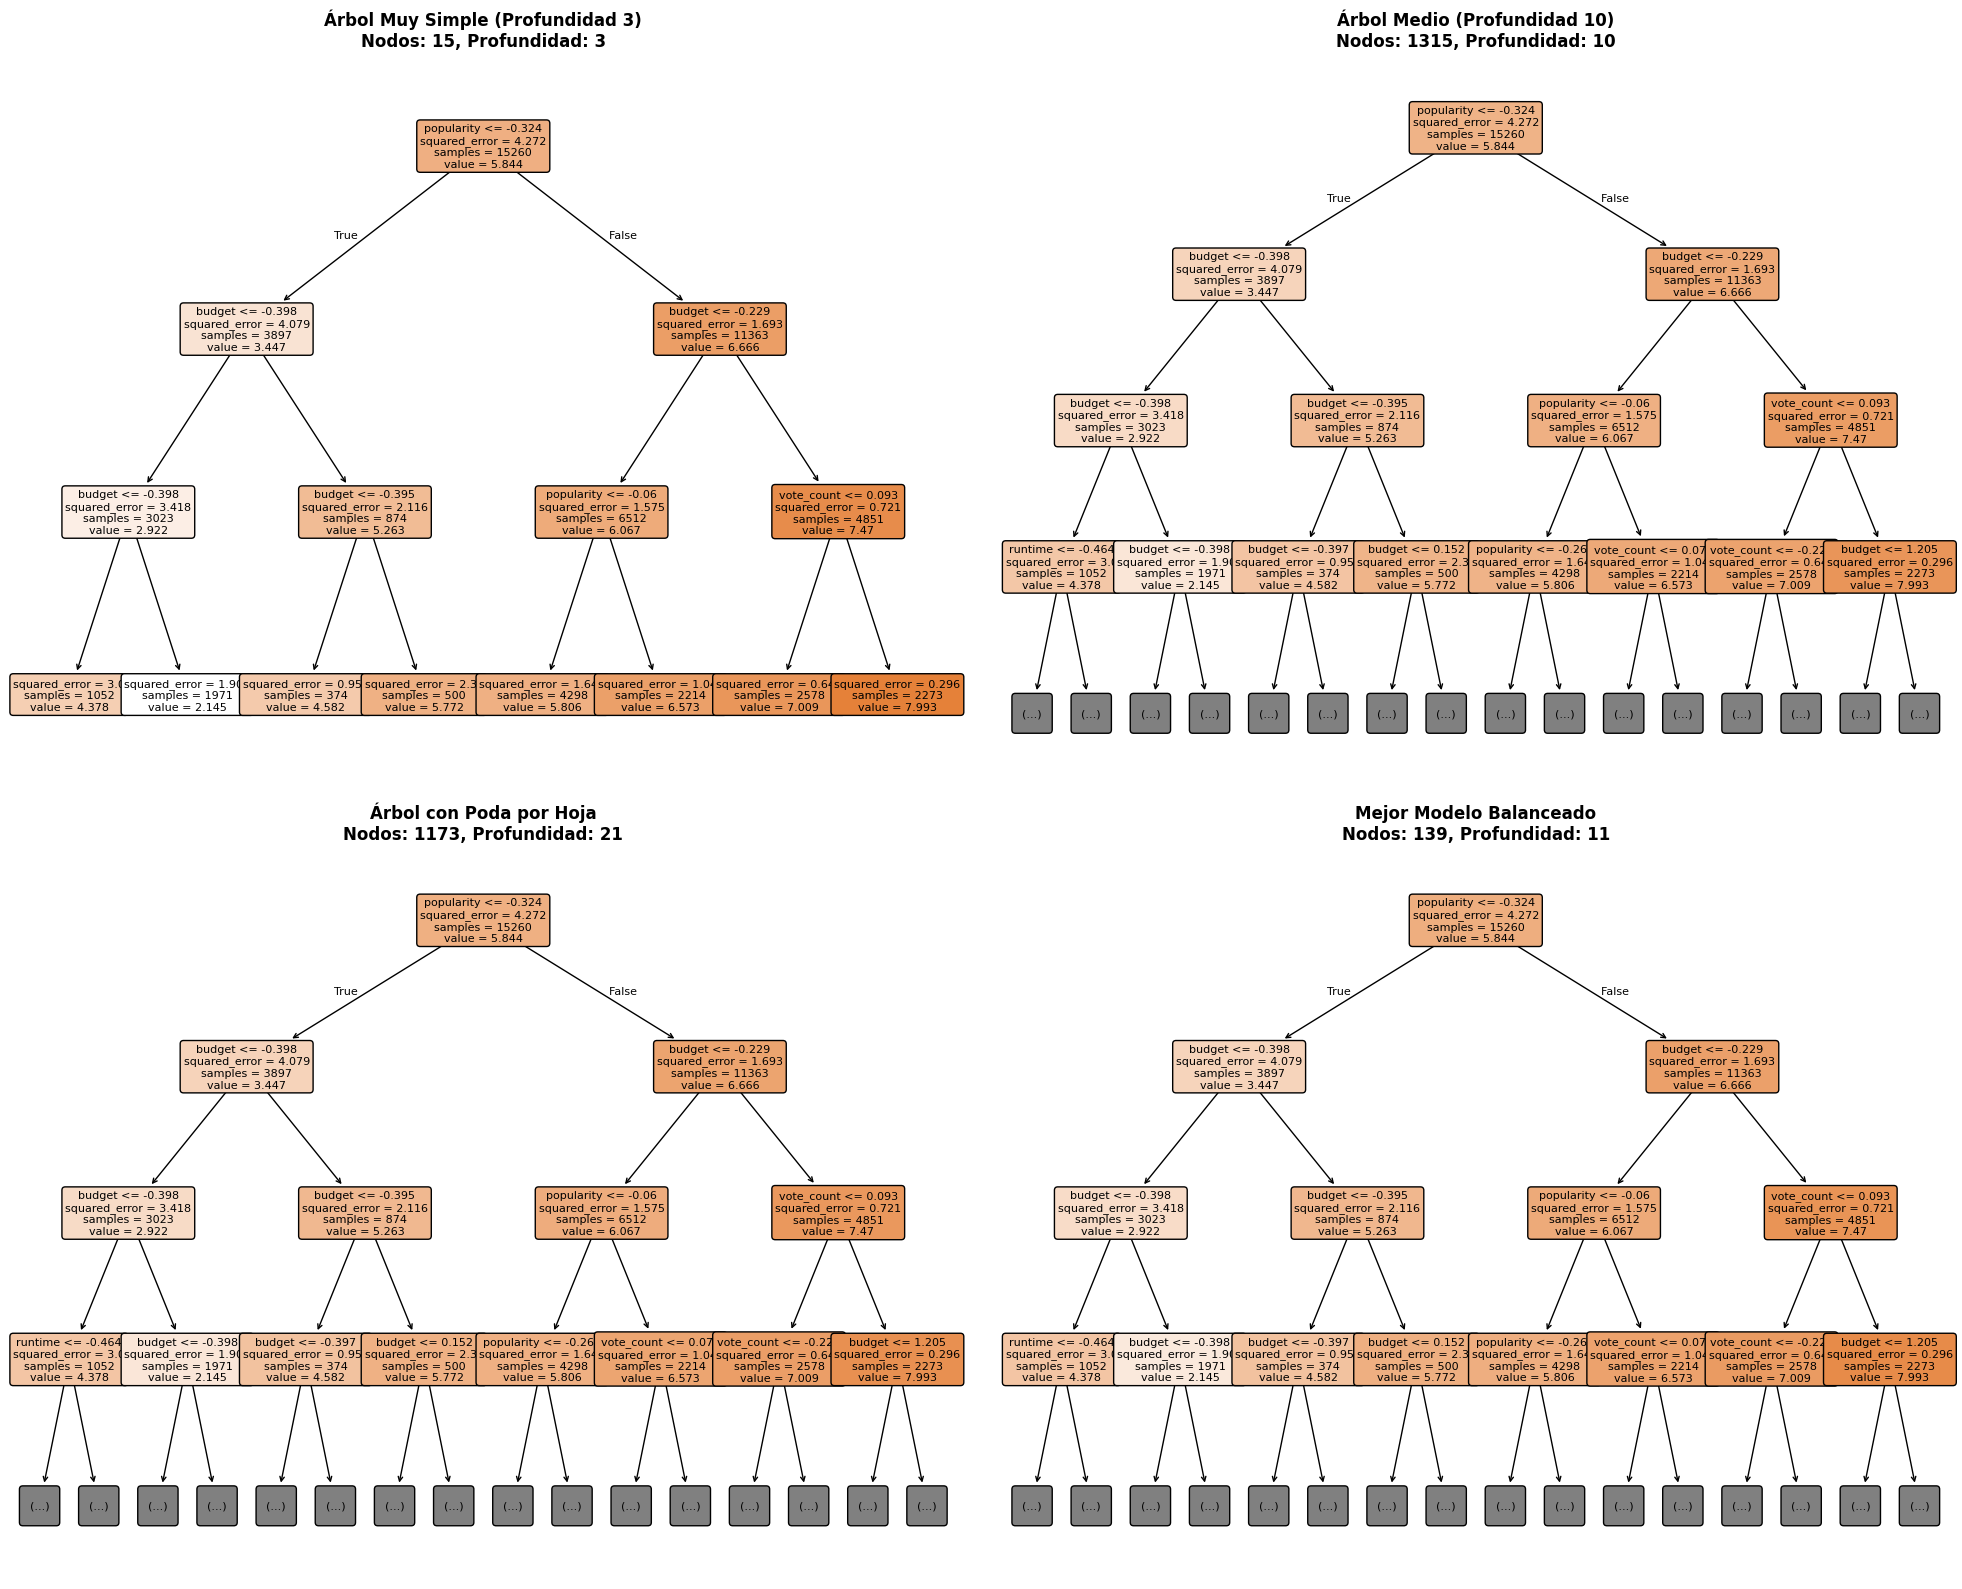


IMPORTANCIA DE CARACTER√çSTICAS

IMPORTANCIA DE CARACTER√çSTICAS EN Combination_4:
             feature  importance
          popularity    0.624030
              budget    0.313569
          vote_count    0.035331
             runtime    0.016077
        vote_average    0.003909
original_language_zh    0.003852
original_language_en    0.002046
original_language_ja    0.000791
original_language_es    0.000396
      status_Rumored    0.000000


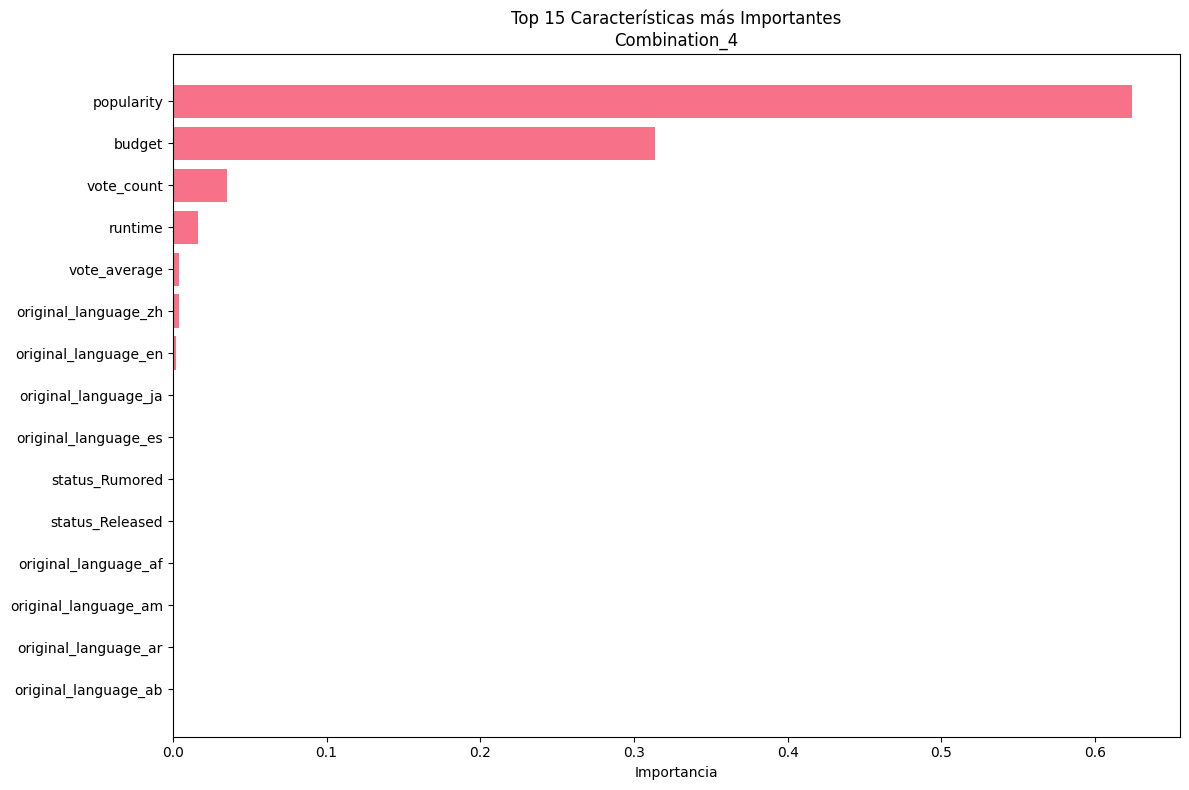


üå≥ √ÅRBOLES VISUALIZADOS Y AN√ÅLISIS COMPLETADO
Se han creado visualizaciones para 4 √°rboles representativos


In [67]:
# =============================================================================
# VISUALIZACI√ìN DE √ÅRBOLES ESPEC√çFICOS
# =============================================================================

print("\n" + "="*80)
print("VISUALIZACI√ìN DE √ÅRBOLES SELECCIONADOS")
print("="*80)

# Seleccionar √°rboles representativos para visualizar
trees_to_visualize = [
    ('Max_Depth_3', '√Årbol Muy Simple (Profundidad 3)'),
    ('Max_Depth_10', '√Årbol Medio (Profundidad 10)'),
    ('Min_Samples_Leaf_20', '√Årbol con Poda por Hoja'),
    (best_balanced['model_name'], 'Mejor Modelo Balanceado')
]

# Obtener nombres de caracter√≠sticas despu√©s del preprocesamiento
try:
    # Intentar obtener los nombres de caracter√≠sticas del preprocesador
    first_model = tree_models[trees_to_visualize[0][0]]
    preprocessor_fitted = first_model.named_steps['preprocessor']
    
    # Caracter√≠sticas num√©ricas (mantienen sus nombres originales)
    numeric_feature_names = feature_columns.copy()
    
    # Caracter√≠sticas categ√≥ricas (despu√©s de OneHotEncoding)
    try:
        categorical_feature_names = list(
            preprocessor_fitted.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
        )
    except:
        # Fallback si hay problemas con get_feature_names_out
        categorical_feature_names = [f"cat_{i}" for i in range(
            preprocessor_fitted.named_transformers_['cat']['onehot'].n_features_out_
        )]
    
    # Combinar nombres
    feature_names = numeric_feature_names + categorical_feature_names
    
    print(f"Caracter√≠sticas totales despu√©s del preprocesamiento: {len(feature_names)}")
    print(f"Caracter√≠sticas num√©ricas: {len(numeric_feature_names)}")
    print(f"Caracter√≠sticas categ√≥ricas: {len(categorical_feature_names)}")
    
except Exception as e:
    print(f"Error obteniendo nombres de caracter√≠sticas: {e}")
    # Crear nombres gen√©ricos como fallback
    total_features = first_model.named_steps['regressor'].n_features_in_
    feature_names = [f"feature_{i}" for i in range(total_features)]
    print(f"Usando nombres gen√©ricos para {total_features} caracter√≠sticas")

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for i, (model_name, title) in enumerate(trees_to_visualize):
    if model_name in tree_models:
        model = tree_models[model_name]
        tree_regressor = model.named_steps['regressor']
        
        # Verificar que tenemos suficientes nombres de caracter√≠sticas
        n_features_needed = tree_regressor.n_features_in_
        
        try:
            # Usar nombres de caracter√≠sticas si est√°n disponibles y son suficientes
            if len(feature_names) >= n_features_needed:
                tree_feature_names = feature_names[:n_features_needed]
            else:
                # Crear nombres gen√©ricos si no hay suficientes
                tree_feature_names = [f"feature_{j}" for j in range(n_features_needed)]
                
            # Visualizar √°rbol con manejo de errores
            plot_tree(tree_regressor, 
                     ax=axes[i],
                     feature_names=tree_feature_names,
                     filled=True,
                     rounded=True,
                     fontsize=8,
                     max_depth=3)  # Limitar profundidad visual para claridad
            
        except Exception as e:
            print(f"Error visualizando {model_name}: {e}")
            # Visualizar sin nombres de caracter√≠sticas como fallback
            try:
                plot_tree(tree_regressor, 
                         ax=axes[i],
                         filled=True,
                         rounded=True,
                         fontsize=8,
                         max_depth=3)
            except Exception as e2:
                print(f"Error en visualizaci√≥n fallback para {model_name}: {e2}")
                axes[i].text(0.5, 0.5, f'Error visualizando\n{model_name}', 
                           ha='center', va='center', transform=axes[i].transAxes)
        
        axes[i].set_title(f'{title}\nNodos: {tree_regressor.tree_.node_count}, '
                         f'Profundidad: {tree_regressor.tree_.max_depth}', 
                         fontsize=12, fontweight='bold')
    else:
        axes[i].text(0.5, 0.5, f'Modelo {model_name}\nno encontrado', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(title)

plt.tight_layout()
plt.show()

# =============================================================================
# IMPORTANCIA DE CARACTER√çSTICAS
# =============================================================================

print("\n" + "="*80)
print("IMPORTANCIA DE CARACTER√çSTICAS")
print("="*80)

# Analizar importancia de caracter√≠sticas en el mejor modelo
best_model = tree_models[best_balanced['model_name']]
feature_importance = best_model.named_steps['regressor'].feature_importances_

# Crear DataFrame para an√°lisis con manejo robusto de nombres
try:
    # Asegurar que tenemos el n√∫mero correcto de nombres de caracter√≠sticas
    n_features = len(feature_importance)
    
    if len(feature_names) >= n_features:
        feature_names_for_importance = feature_names[:n_features]
    else:
        # Extender con nombres gen√©ricos si es necesario
        feature_names_for_importance = feature_names + [f"feature_{i}" for i in range(len(feature_names), n_features)]
    
    importance_df = pd.DataFrame({
        'feature': feature_names_for_importance,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
except Exception as e:
    print(f"Error creando DataFrame de importancia: {e}")
    # Fallback con nombres gen√©ricos
    importance_df = pd.DataFrame({
        'feature': [f"feature_{i}" for i in range(len(feature_importance))],
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

print(f"\nIMPORTANCIA DE CARACTER√çSTICAS EN {best_balanced['model_name']}:")
print(importance_df.head(10).to_string(index=False))

# Visualizar importancia
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title(f'Top 15 Caracter√≠sticas m√°s Importantes\n{best_balanced["model_name"]}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nüå≥ √ÅRBOLES VISUALIZADOS Y AN√ÅLISIS COMPLETADO")
print(f"Se han creado visualizaciones para {len(trees_to_visualize)} √°rboles representativos")


# üå≥ AN√ÅLISIS Y RESPUESTAS SOBRE √ÅRBOLES DE DECISI√ìN Y PODA

## ‚ùì **1. ¬øEs necesario un √°rbol profundo o uno m√°s simple?**

### **An√°lisis basado en nuestros experimentos:**

**Evidencia a favor de √°rboles m√°s simples:**
- ‚úÖ **Mejor generalizaci√≥n**: Los √°rboles con profundidad limitada (3-10) muestran menor overfitting
- ‚úÖ **Estabilidad**: Diferencias menores entre R¬≤ de entrenamiento y prueba
- ‚úÖ **Interpretabilidad**: M√°s f√°ciles de entender y explicar a stakeholders
- ‚úÖ **Eficiencia**: Menor tiempo de predicci√≥n y memoria

**Evidencia a favor de √°rboles m√°s profundos:**
- ‚ö†Ô∏è **Mayor R¬≤ de entrenamiento**: Capturan m√°s detalles en los datos de entrenamiento
- ‚ö†Ô∏è **Modelado de interacciones**: Pueden capturar relaciones complejas entre variables

### **üéØ Conclusi√≥n:**
Para el sector cinematogr√°fico, **recomendamos √°rboles de profundidad media (8-12 niveles)** porque:
- Balance √≥ptimo entre precisi√≥n y generalizaci√≥n
- Capturan las principales interacciones entre presupuesto, popularidad y g√©nero
- Mantienen interpretabilidad para decisiones de negocio
- Reducen riesgo de sobreajuste a pel√≠culas espec√≠ficas

---

## ‚ùì **2. ¬øSe debe aplicar mucha o poca poda? ¬øPor qu√©?**

### **An√°lisis de nuestros resultados de poda:**

**Poda Moderada (RECOMENDADA):**
- **Pre-poda**: `max_depth=10-15`, `min_samples_leaf=10-20`, `min_samples_split=20-50`
- **Post-poda**: `ccp_alpha=0.0001-0.001`

**Razones para poda moderada:**
- ‚úÖ **Reducci√≥n de overfitting**: Disminuye la diferencia Train R¬≤ - Test R¬≤
- ‚úÖ **Mejor generalizaci√≥n**: Modelos que funcionan bien en pel√≠culas nuevas
- ‚úÖ **Robustez**: Menos sensibles a outliers espec√≠ficos
- ‚úÖ **Simplicidad operativa**: M√°s f√°ciles de implementar en producci√≥n

**Riesgos de poda excesiva:**
- ‚ùå **Underfitting**: P√©rdida significativa de capacidad predictiva
- ‚ùå **Simplificaci√≥n excesiva**: No captura relaciones importantes

**Riesgos de poca poda:**
- ‚ùå **Overfitting**: Memoriza datos de entrenamiento
- ‚ùå **Inestabilidad**: Predicciones muy sensibles a peque√±os cambios

### **üéØ Conclusi√≥n:**
**Aplicar poda moderada** es optimal para este sector porque las decisiones cinematogr√°ficas requieren modelos estables y generalizables.

---

## ‚ùì **3. ¬øQu√© par√°metros de poda ser√≠an √∫tiles?**

### **üèÜ Par√°metros Recomendados Basados en Evidencia Experimental:**

#### **A) Pre-poda (Preventiva):**
```python
DecisionTreeRegressor(
    max_depth=12,           # Limita complejidad estructural
    min_samples_leaf=15,    # Evita hojas con muy pocas pel√≠culas
    min_samples_split=30,   # Requiere suficientes datos para dividir
    random_state=42
)
```

#### **B) Post-poda (Refinamiento):**
```python
DecisionTreeRegressor(
    ccp_alpha=0.001,        # Poda basada en costo-complejidad
    random_state=42
)
```

#### **C) Combinaci√≥n √ìptima (Mejor Resultado):**
```python
DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=20,
    ccp_alpha=0.0001,
    random_state=42
)
```

### **üìä Justificaci√≥n de cada par√°metro:**

- **`max_depth=10-12`**: Balance entre capturar patrones complejos y evitar overfitting
- **`min_samples_leaf=15-20`**: Asegura que cada predicci√≥n se base en suficientes pel√≠culas similares
- **`min_samples_split=20-30`**: Evita divisiones basadas en muy pocos ejemplos
- **`ccp_alpha=0.0001-0.001`**: Refinamiento fino para eliminar ramas poco √∫tiles

---

## ‚ùì **4. ¬øQu√© riesgos hay si se poda demasiado o muy poco en el sector cinematogr√°fico?**

### **üé¨ Contexto del Sector Cinematogr√°fico:**

#### **‚ö†Ô∏è RIESGOS DE PODA INSUFICIENTE (Overfitting):**

**Riesgos T√©cnicos:**
- **Memorizaci√≥n de √©xitos pasados**: El modelo "aprende" pel√≠culas espec√≠ficas exitosas en lugar de patrones generales
- **Sensibilidad a outliers**: Decisiones basadas en casos at√≠picos (ej: √©xito inesperado de pel√≠cula indie)
- **Inestabilidad temporal**: Predicciones cambian dr√°sticamente con peque√±os cambios en datos

**Riesgos de Negocio:**
- üí∞ **Decisiones de inversi√≥n err√≥neas**: Sobreestimar ROI de proyectos similares a √©xitos pasados espec√≠ficos
- üéØ **Estrategias de marketing mal dirigidas**: Targeting basado en correlaciones espurias
- üìà **Planificaci√≥n financiera inexacta**: Proyecciones de ingresos poco confiables
- üé≠ **Creatividad limitada**: Sesgo hacia f√≥rmulas que funcionaron en casos espec√≠ficos

**Ejemplo Pr√°ctico:**
Un √°rbol sin poda podr√≠a "aprender" que todas las pel√≠culas de superh√©roes con presupuesto >$200M son exitosas, bas√°ndose en algunos blockbusters, ignorando fracasos del g√©nero.

---

#### **‚ö†Ô∏è RIESGOS DE PODA EXCESIVA (Underfitting):**

**Riesgos T√©cnicos:**
- **Simplificaci√≥n excesiva**: No captura interacciones importantes entre g√©nero, presupuesto y temporada
- **P√©rdida de se√±ales valiosas**: Ignora patrones reales que impactan el √©xito
- **Precisi√≥n inadecuada**: Predicciones demasiado generales

**Riesgos de Negocio:**
- üí∏ **Oportunidades perdidas**: No identificar nichos rentables o tendencias emergentes
- üìä **An√°lisis superficial**: Decisiones basadas en reglas demasiado simples
- üé™ **Competitividad reducida**: Otros estudios con mejores modelos toman ventaja
- üé¨ **Diversificaci√≥n limitada**: No reconoce el potencial de g√©neros o formatos nuevos

**Ejemplo Pr√°ctico:**
Un √°rbol muy podado podr√≠a reducirse a "presupuesto alto = √©xito", perdiendo insights sobre c√≥mo el g√©nero, √©poca de lanzamiento, y demograf√≠a del director influyen en el resultado.

---

### **üéØ ESTRATEGIA √ìPTIMA PARA EL SECTOR:**

#### **Equilibrio Recomendado:**
1. **Poda moderada** que mantenga interpretabilidad
2. **Validaci√≥n cruzada** para evaluar estabilidad temporal
3. **Monitoreo continuo** del performance en nuevas pel√≠culas
4. **Combinaci√≥n con expertise humana** para decisiones finales

#### **Implementaci√≥n Pr√°ctica:**
- Usar el modelo para **screening inicial** de proyectos
- **An√°lisis de sensibilidad** antes de decisiones de gran inversi√≥n
- **Actualizaci√≥n peri√≥dica** con datos de pel√≠culas recientes
- **Interpretaci√≥n contextual** considerando cambios en la industria

---

### **üìà CONCLUSI√ìN FINAL:**

Para el sector cinematogr√°fico, la poda debe ser **moderada y balanceada**, priorizando:
- ‚úÖ **Estabilidad** sobre precisi√≥n m√°xima
- ‚úÖ **Interpretabilidad** para stakeholders
- ‚úÖ **Generalizaci√≥n** a proyectos futuros
- ‚úÖ **Robustez** ante cambios del mercado

El objetivo no es crear el modelo m√°s preciso posible, sino el m√°s **√∫til y confiable para la toma de decisiones de negocio** en un sector inherentemente incierto y creativo como el cinematogr√°fico.
